In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import numpy as np

from tmm_ml_models import ForwardTMMModel, ReverseTMMModel
import matplotlib.pyplot as plt

data = pd.read_csv("R.csv")

2023-06-25 16:44:03.401038: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 16:44:03.440743: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 16:44:03.441362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 16:44:04.095234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

output_values = labels[feature_headings]
input_features = labels[[c for c in labels.columns if c not in feature_headings]]

input_train, input_test, output_train, output_test = train_test_split(input_features, output_values, test_size=0.2, random_state=42)

In [3]:
reverse_model = ReverseTMMModel(retrain=True, serialised_model_path="reverse_model_v2_medium_layers_dropout")

if not reverse_model.is_trained:
    history = reverse_model.train(input_train, output_train, epochs=500)

Epoch 1/500
675/675 [==============================] - 6s 7ms/step - loss: 9.6641 - first_layer_loss: 3.0826 - second_layer_loss: 3.2506 - thicknesses_loss: 333.0969 - first_layer_accuracy: 0.1190 - second_layer_accuracy: 0.0890 - thicknesses_MSE: 333.0969 - val_loss: 8.5852 - val_first_layer_loss: 2.6831 - val_second_layer_loss: 3.0333 - val_thicknesses_loss: 286.8880 - val_first_layer_accuracy: 0.2438 - val_second_layer_accuracy: 0.1479 - val_thicknesses_MSE: 286.8880
Epoch 2/500
675/675 [==============================] - 5s 7ms/step - loss: 8.5254 - first_layer_loss: 2.5996 - second_layer_loss: 3.0121 - thicknesses_loss: 291.3711 - first_layer_accuracy: 0.2264 - second_layer_accuracy: 0.1462 - thicknesses_MSE: 291.3711 - val_loss: 8.1808 - val_first_layer_loss: 2.4539 - val_second_layer_loss: 2.9176 - val_thicknesses_loss: 280.9315 - val_first_layer_accuracy: 0.3088 - val_second_layer_accuracy: 0.1863 - val_thicknesses_MSE: 280.9315
Epoch 3/500
675/675 [=============================

In [47]:
## Plot a graph of the model layers

from keras.utils.vis_utils import plot_model

# plot_model(reverse_model.model, "images/reverse_model.png", show_layer_names=True, show_dtype=True, show_shapes=True)

In [20]:
# Allows model to be saved to disk

answer = input("Would you like to save the trained model? (Y/N)")

match answer:
    case "Y":
        reverse_model.save()
    case other:
        print("Model not saved")


2023-06-25 17:29:20.824280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-06-25 17:29:20.837660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-06-25 17:29:20.849507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-06-25 17:29

INFO:tensorflow:Assets written to: reverse_model_v2_medium_layers_dropout/assets


INFO:tensorflow:Assets written to: reverse_model_v2_medium_layers_dropout/assets


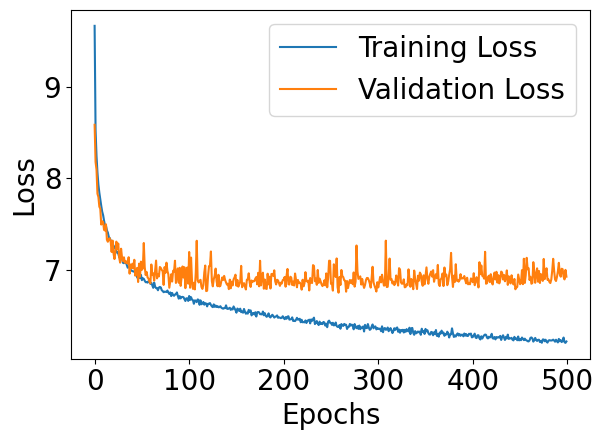

In [29]:
plt.rc("font", size=20)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

plt.savefig("images/reverse_model_loss.png")

In [5]:
forward_model = ForwardTMMModel(serialised_model_path="forward_model_v1_FINAL")

if not forward_model.is_trained:
    forward_model.train(output_train, input_train)

1/1 [==============================] - 0s 20ms/step


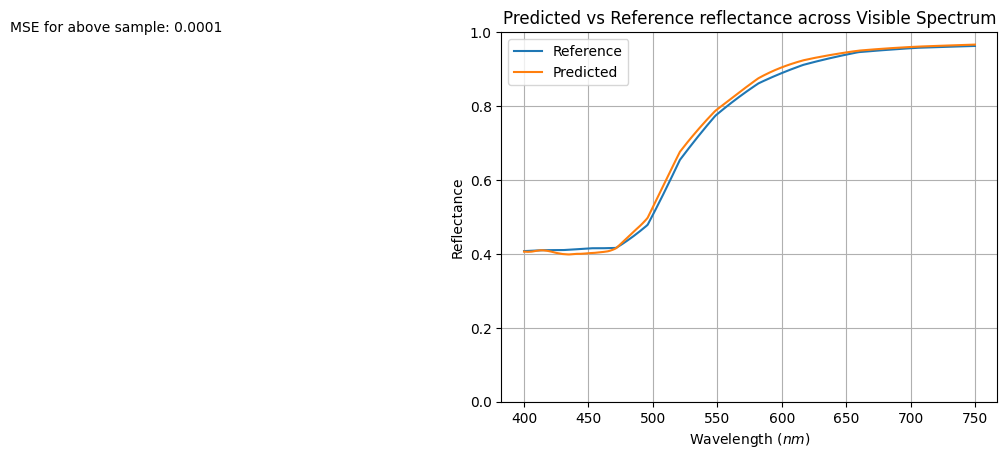

In [19]:
index = random.randint(0, len(input_test) - 1)
input_sample = input_test.iloc[[index]]

# input_sample = pd.DataFrame(np.array([[0.2 if x < 600 else 0.8 for x in range(400,751)]]))

output_sample = output_test.iloc[[index]]
mat_predict = reverse_model.predict(input_sample)
pred = mat_predict[["First Layer", "Second Layer"]]
act = output_sample[["First Layer", "Second Layer"]]

reference_waveform = input_sample
predicted_waveform = forward_model.predict(mat_predict)



x = np.arange(400,751)


plt.plot(x, reference_waveform.values.T, label="Reference")
plt.plot(x, predicted_waveform.values.T, label="Predicted")

plt.ylim((0,1))
plt.xlabel(r"Wavelength ($nm$)")
plt.ylabel("Reflectance")
plt.grid()
plt.title("Predicted vs Reference reflectance across Visible Spectrum")

se = (reference_waveform.T.values - predicted_waveform.T.values) ** 2

plt.text(1,1,f"MSE for above sample: {((sum(se))/len(se))[0]:.4f}")

plt.legend()

In [40]:
mat_predict.head()

,d1,d2,d3,d4,d5,d6,First Layer,Second Layer
19416,34.466736,34.945946,37.305069,34.441715,34.599331,34.938313,Sc2O3,Sc2O3


In [41]:
output_sample.head()

,d1,d2,d3,d4,d5,d6,First Layer,Second Layer
19416,40,60,20,50,10,40,Ta2O5,MgO


In [20]:
reverse_model.evaluate(input_sample, output_sample)

1/1 [==============================] - 0s 35ms/step - loss: 16.4165 - first_layer_loss: 3.6430 - second_layer_loss: 11.7633 - thicknesses_loss: 101.0231 - first_layer_First_Layer_Accuracy: 0.0000e+00 - second_layer_Second_Layer_Accuracy: 0.0000e+00 - thicknesses_Thickness_MSE: 101.0231


[16.416501998901367,
 3.6429800987243652,
 11.763290405273438,
 101.02306365966797,
 0.0,
 0.0,
 101.02306365966797]